In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from os import listdir

exp_path = '../experiments'

In [6]:
def load_results(f_name):
    out = []
    for dir in listdir(exp_path):
        if dir.startswith('2024') and 'rerun' not in dir:
            df = pd.read_csv(f'{exp_path}/{dir}/{f_name}')
            psi = float(dir.split('_')[-1])
            df['psi'] = psi
            out.append(df)
    return pd.concat(out)

# runtime analysis

In [7]:
# Load data
runtimes = load_results('epoch_runtimes.csv')

# Load chap3 data as comparison
chap3_runtimes = pd.read_csv('../experiments/20240603-130535-rerun_simple_selfloops_21/epoch_runtimes.csv')
chap3_runtimes['psi'] = 0.0

# Format
runtimes = pd.concat([runtimes, chap3_runtimes])
runtimes['psi_s'] = [f'{val:.0e}' if val > 0 else 'N/A\n(Chapter 3)' for val in runtimes.psi.values]
runtimes.sort_values('psi', inplace=True)
runtimes

,epoch,runtime,psi,psi_s
34,35,108.651573,0.0,N/A\n(Chapter 3)
13,14,108.543760,0.0,N/A\n(Chapter 3)
12,13,108.540734,0.0,N/A\n(Chapter 3)
11,12,107.764811,0.0,N/A\n(Chapter 3)
10,11,106.867724,0.0,N/A\n(Chapter 3)
...,...,...,...,...
19,20,242.455518,0.1,1e-01
20,21,247.032435,0.1,1e-01
21,22,244.385233,0.1,1e-01
23,24,242.880105,0.1,1e-01


/var/folders/_x/2pk9s5z166x9c0h399wmby_h0000gp/T/ipykernel_17989/28410350.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(runtimes, x='psi_s', y='runtime', ci='sd')


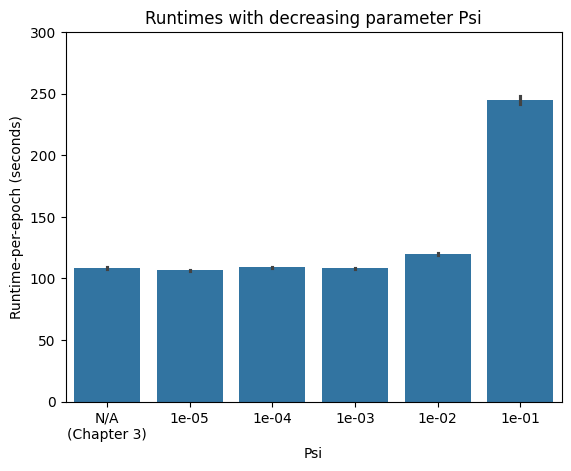

In [8]:
# Draw figure
sns.barplot(runtimes, x='psi_s', y='runtime', ci='sd')

# Fig labels
plt.title('Runtimes with decreasing parameter Psi')
plt.ylabel('Runtime-per-epoch (seconds)')
plt.xlabel('Psi')

# Vertical separator
ymin, ymax = 0, 300
#plt.vlines(x=0.5, ymin=ymin, ymax=ymax, colors='red', linestyles='--')
plt.ylim(ymin, ymax)

# Save
plt.savefig('runtimes_vs_chap3.png', bbox_inches="tight")

In [47]:
for psi, subdf in runtimes.groupby('psi'):
    print(psi, subdf.runtime.mean(), subdf.runtime.std())

0.0 118.61493791675568 0.2751393391404155
1e-05 106.35729407163767 0.21703601524068383
0.0001 108.98407531314426 0.48493729335112656
0.001 108.29599866133469 0.3914179976173397
0.01 119.65406321525573 0.9462993014805094
0.1 244.7106959104538 3.102622229618412


# PolySE results with decreasing Psi

In [6]:
polySE = load_results('polySE_results_aggregations.csv')

psi_075 = pd.read_csv('../../1_general_assessment/experiments/morgan/morgan_n20/20240524-070322-morgan_n20_psi_0.75/polySE_results_aggregations.csv')
psi_075['psi'] = 0.75

chap4 = pd.read_csv('../../../../Chapter4/data/results/polySE.csv')
chap4.query('neighbourhood_method == "drug similarity" and vector_method == "mean components"', inplace=True)
chap4.drop(columns=['neighbourhood_method', 'vector_method'], inplace=True)
chap4['psi'] = 0.0

polySE = pd.concat([polySE, psi_075, chap4])

# Create x tick labels
psi_s = []
for val in polySE.psi.values:
    if val == 0:
        psi_s.append('N/A\n(Chapter 4)')
    elif val < 0.75:
        psi_s.append(f'{val:.0e}')
    else:
        psi_s.append(0.75)
polySE['psi_s'] = psi_s
polySE['Scenario'] = ['Cold-start' if s == 'both' else 'Warm-start' for s in polySE.fake_triple_component]
polySE.sort_values('psi', inplace=True)
polySE

,side_effect,fake_triple_component,AUROC,AUPRC,AP50,psi,psi_s,Scenario
23105,C0020625,tail,0.817703,0.788469,0.877383,0.00,N/A\n(Chapter 4),Warm-start
7743,C0019284,both,0.507031,0.513896,0.296260,0.00,N/A\n(Chapter 4),Cold-start
7721,C0019270,tail,0.871669,0.833729,0.746449,0.00,N/A\n(Chapter 4),Warm-start
7720,C0019270,head,0.786774,0.770904,0.836908,0.00,N/A\n(Chapter 4),Warm-start
7719,C0019270,both,0.599402,0.584230,0.456024,0.00,N/A\n(Chapter 4),Cold-start
...,...,...,...,...,...,...,...,...
1921,C0039503,tail,0.897297,0.865473,0.869466,0.75,0.75,Warm-start
1920,C0039503,head,0.870610,0.833243,0.766191,0.75,0.75,Warm-start
1919,C0039483,both,0.676538,0.615037,0.393929,0.75,0.75,Cold-start
1917,C0039483,head,0.926768,0.903346,0.859138,0.75,0.75,Warm-start


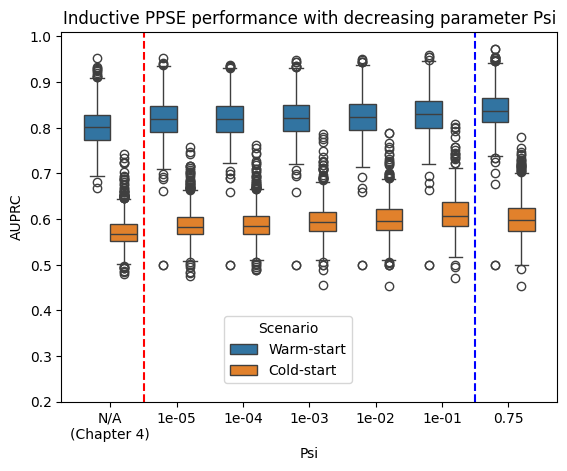

In [8]:
sns.boxplot(polySE, x='psi_s', y='AUPRC', hue='Scenario')

plt.title('Inductive PPSE performance with decreasing parameter Psi')
plt.xlabel('Psi')

ymin, ymax = 0.2, 1.01
plt.vlines(x = 0.5, ymin=ymin, ymax=ymax, colors='red', linestyles='--')
plt.vlines(x = 5.5, ymin=ymin, ymax=ymax, colors='blue', linestyles='--')
plt.ylim(ymin, ymax)
plt.legend(bbox_to_anchor=(0.6, 0.25), title='Scenario')

plt.savefig('AUPRC_vs_chap4_and_part1.png', bbox_inches="tight")


In [49]:
for tup, subdf in polySE.groupby(['Scenario', 'psi']):
    print(tup, subdf.AUPRC.median())

('Cold-start', 0.0) 0.5678348031246792
('Cold-start', 1e-05) 0.5823704655917843
('Cold-start', 0.0001) 0.5847230761211174
('Cold-start', 0.001) 0.5934156643721249
('Cold-start', 0.01) 0.5964000536123397
('Cold-start', 0.1) 0.6071876505678191
('Cold-start', 0.75) 0.5979425804759245
('Warm-start', 0.0) 0.8005534279019861
('Warm-start', 1e-05) 0.8189699554917851
('Warm-start', 0.0001) 0.8181117094758109
('Warm-start', 0.001) 0.8202650496055748
('Warm-start', 0.01) 0.8227678107885452
('Warm-start', 0.1) 0.8301238001635394
('Warm-start', 0.75) 0.8376743379373741
